In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)

/home/user_3/medistream-recsys/Script


In [2]:
df = pd.read_json('/fastcampus-data/select_column_version_4.json')
df

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
0,5d60cebb4e77525ec5ca141c,None,NaN,NaN,NaN,None,5d60cea34e77525ec5ca1413,False,None,None,None,NaN,NaN,NaN,20-29,1.0,0.0,False,None,None
1,5d60daf14e77525ec5ca1497,2019-08-21T05:04:55.728Z,66000.0,0.0,NaN,None,5d60ceba4e77525ec5ca1419,False,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,20-29,1.0,0.0,True,의약품,medicine
2,5d60d2d04e77525ec5ca145b,2019-08-21T05:04:55.728Z,66000.0,0.0,NaN,2019-09-06T09:13:26.749Z,5d60d0a94e77525ec5ca1446,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,30-39,0.0,1.0,False,의약품,medicine
3,5d60e27c4e77525ec5ca14b6,2019-10-16T04:03:00.777Z,44800.0,37900.0,0.0,2019-10-21T02:18:23.528Z,5d60e2694e77525ec5ca14b5,True,"한의원 원장님도 기획자가 돼야한다 생각한다면, 읽어야 하는 책",5cf8bbba0098b2225c5dfaa3,5da696740dabe405b156eb5c,1.0,37000.0,37000.0,20-29,0.0,0.0,False,도서,book
4,5d60f8764e77525ec5ca14e5,None,NaN,NaN,NaN,None,5d60f3a74e77525ec5ca14da,False,None,None,None,NaN,NaN,NaN,40-49,1.0,1.0,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266653,632044cb6c2e37002369f129,2022-02-16T04:01:35.033Z,41500.0,35200.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 황기(편) (5묶음) 600g*5ea, 중국",5fb32f7a5120316334323fd8,620c771fd41623002392d61b,1.0,35200.0,35200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266654,632044cb6c2e37002369f129,2020-11-20T06:59:35.395Z,4900.0,4200.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 어성초 600g, 중국",5fb32f7a5120316334323fd8,5fb769575120316334324a69,1.0,4200.0,4200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266655,632044cb6c2e37002369f129,2020-11-20T06:59:36.047Z,3900.0,3300.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 여정실 600g, 중국",5fb32f7a5120316334323fd8,5fb769585120316334324a6a,1.0,3300.0,3300.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266656,632045696c2e37002369f136,2022-08-30T00:42:13.239Z,330000.0,0.0,386.0,2022-09-13T08:59:21.151Z,628ecb419d9388002406f007,True,맘 편하게 한약 처방하기,5ea40b671a3ca36b967849ad,630d5ce568554000236d9a5d,1.0,264000.0,264000.0,None,1.0,0.0,False,온라인 강의,lecture


In [3]:
date_state = "2022-05-12"

# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# 3개월치 데이터만 가져오기
df_date = df_only_paid[df_only_paid['date_paid'] > date_state]
# 취소 안된 것만 가져오기
complete_df = df_date[(df_date['paid'] == True) & (df_date['cancelled']==False)]
# # 도서 카테고리만 가져오기
# only_book = complete_df[complete_df['name'] == '도서']

# 유저가 중복으로 아이템 구매 삭제
df_duplicated_book = complete_df.drop_duplicates(subset=['customer_id','product_ids'])
df_all = df_duplicated_book.sort_values(by='date_paid').reset_index(drop=True)


In [4]:
df_all['name'].value_counts()

온라인 강의     30994
도서          5910
소모품         3422
한약재         3175
의료기기        1050
식품           957
의약품          890
메디TV         840
치료실 물품       718
의류/잡화        666
생활           582
오프라인 강의      292
가전/가구        234
디자인          122
구독            95
해부학 모형        64
재활 용품         47
약속처방          37
기타            27
기획서비스          3
Name: name, dtype: int64

In [5]:
df_all[['product_ids','name_x']].value_counts()

product_ids               name_x                         
62821ca79d93880024064505  [제32기 전졸협] 국시특강 간계내과학              828
62821e079d93880024064575  [제32기 전졸협] 국시특강 신경정신과학             828
62821d249d93880024064523  [제32기 전졸협] 국시특강 폐계내과학              828
62821d459d9388002406452b  [제32기 전졸협] 국시특강 신계내과학              828
62821d649d93880024064536  [제32기 전졸협] 국시특강 상한론                828
                                                            ... 
5fa8e38751203163343224c4  일차진료아카데미 처방가이드                       1
5f167b2f221c8b5f77c8f6a4  신경블록 술기 아틀라스                         1
609a3735c1908b001a6418f8  [신흥제약] 황기밀자 중국 500g, 중국              1
62905a5e9d9388002406f83c  아스페카 스트레이트 스크럽 여성 팬츠 Royal Blue      1
60dbdd89d26af90681b1a3d5  에이치알메디텍 미용기 스킨프로                     1
Length: 2029, dtype: int64

In [6]:
df_all['date_paid'] = df_all['date_paid'].dt.strftime('%m/%d/%Y')

In [7]:
df_all.pivot_table('quantity','name_x','date_paid',aggfunc='sum',margins=True).sort_values(by='All',ascending=False).head(10)

date_paid,05/12/2022,05/13/2022,05/14/2022,05/15/2022,05/16/2022,05/17/2022,05/18/2022,05/19/2022,05/20/2022,05/21/2022,05/22/2022,05/23/2022,05/24/2022,05/25/2022,05/26/2022,05/27/2022,05/28/2022,05/29/2022,05/30/2022,05/31/2022,06/01/2022,06/02/2022,06/03/2022,06/04/2022,06/05/2022,06/06/2022,06/07/2022,06/08/2022,06/09/2022,06/10/2022,06/11/2022,06/12/2022,06/13/2022,06/14/2022,06/15/2022,06/16/2022,06/17/2022,06/18/2022,06/19/2022,06/20/2022,06/21/2022,06/22/2022,06/23/2022,06/24/2022,06/25/2022,06/26/2022,06/27/2022,06/28/2022,06/29/2022,06/30/2022,...,07/27/2022,07/28/2022,07/29/2022,07/30/2022,07/31/2022,08/01/2022,08/02/2022,08/03/2022,08/04/2022,08/05/2022,08/06/2022,08/07/2022,08/08/2022,08/09/2022,08/10/2022,08/11/2022,08/12/2022,08/13/2022,08/14/2022,08/15/2022,08/16/2022,08/17/2022,08/18/2022,08/19/2022,08/20/2022,08/21/2022,08/22/2022,08/23/2022,08/24/2022,08/25/2022,08/26/2022,08/27/2022,08/28/2022,08/29/2022,08/30/2022,08/31/2022,09/01/2022,09/02/2022,09/03/2022,09/04/2022,09/05/2022,09/06/2022,09/07/2022,09/08/2022,09/09/2022,09/10/2022,09/11/2022,09/12/2022,09/13/2022,All
name_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
All,415.0,269.0,182.0,137.0,508.0,400.0,243.0,278.0,14212.0,2487.0,61.0,436.0,454.0,403.0,422.0,343.0,131.0,96.0,737.0,698.0,334.0,311.0,349.0,107.0,71.0,89.0,360.0,3786.0,323.0,407.0,91.0,90.0,479.0,517.0,214.0,341.0,361.0,118.0,94.0,454.0,378.0,286.0,438.0,324.0,91.0,135.0,547.0,455.0,655.0,3155.0,...,298.0,491.0,381.0,83.0,137.0,512.0,398.0,233.0,295.0,343.0,98.0,110.0,405.0,382.0,400.0,475.0,1786.0,62.0,35.0,105.0,431.0,249.0,223.0,258.0,79.0,67.0,295.0,526.0,292.0,203.0,296.0,143.0,123.0,319.0,683.0,483.0,493.0,448.0,94.0,173.0,277.0,282.0,195.0,286.0,42.0,21.0,50.0,139.0,361.0,63942.0
[제32기 전졸협] 국시특강 상한론,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828.0
[제32기 전졸협] 국시특강 폐계내과학,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828.0
[제32기 전졸협] 국시특강 침구학,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828.0
[제32기 전졸협] 국시특강 외과학,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828.0
[제32기 전졸협] 국시특강 예방의학,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828.0
[제32기 전졸협] 국시특강 안이비인후과학,NaN,NaN,Na

# lecture와 book의 상관관계가 있을까?

In [14]:
df_book_lec = df_all.loc[(df_all['name'] == '도서') | (df_all['name'] == '온라인 강의')]
df_book = df_all.loc[(df_all['name'] == '도서')]
df_lec = df_all.loc[(df_all['name'] == '온라인 강의')]

In [60]:
book_pivot = df_book.pivot_table('quantity','name_x','date_paid',aggfunc='sum',margins=True).sort_values(by='All',ascending=False)
lec_pivot = df_lec.pivot_table('quantity','name_x','date_paid',aggfunc='sum',margins=True).sort_values(by='All',ascending=False)
book_pivot

date_paid,05/12/2022,05/13/2022,05/14/2022,05/15/2022,05/16/2022,05/17/2022,05/18/2022,05/19/2022,05/20/2022,05/21/2022,05/22/2022,05/23/2022,05/24/2022,05/25/2022,05/26/2022,05/27/2022,05/28/2022,05/29/2022,05/30/2022,05/31/2022,06/01/2022,06/02/2022,06/03/2022,06/04/2022,06/05/2022,06/06/2022,06/07/2022,06/08/2022,06/09/2022,06/10/2022,06/11/2022,06/12/2022,06/13/2022,06/14/2022,06/15/2022,06/16/2022,06/17/2022,06/18/2022,06/19/2022,06/20/2022,06/21/2022,06/22/2022,06/23/2022,06/24/2022,06/25/2022,06/26/2022,06/27/2022,06/28/2022,06/29/2022,06/30/2022,07/01/2022,07/02/2022,07/03/2022,07/04/2022,07/05/2022,07/06/2022,07/07/2022,07/08/2022,07/09/2022,07/10/2022,07/11/2022,07/12/2022,07/13/2022,07/14/2022,07/15/2022,07/16/2022,07/17/2022,07/18/2022,07/19/2022,07/20/2022,07/21/2022,07/22/2022,07/23/2022,07/24/2022,07/25/2022,07/26/2022,07/27/2022,07/28/2022,07/29/2022,07/30/2022,07/31/2022,08/01/2022,08/02/2022,08/03/2022,08/04/2022,08/05/2022,08/06/2022,08/07/2022,08/08/2022,08/09/2022,08/10/2022,08/11/2022,08/12/2022,08/13/2022,08/14/2022,08/15/2022,08/16/2022,08/17/2022,08/18/2022,08/19/2022,08/20/2022,08/21/2022,08/22/2022,08/23/2022,08/24/2022,08/25/2022,08/26/2022,08/27/2022,08/28/2022,08/29/2022,08/30/2022,08/31/2022,09/01/2022,09/02/2022,09/03/2022,09/04/2022,09/05/2022,09/06/2022,09/07/2022,09/08/2022,09/09/2022,09/10/2022,09/11/2022,09/12/2022,09/13/2022,All
name_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
All,93.0,22.0,7.0,6.0,52.0,25.0,25.0,75.0,10.0,10.0,7.0,101.0,44.0,44.0,155.0,17.0,9.0,6.0,71.0,46.0,19.0,63.0,23.0,8.0,11.0,13.0,59.0,51.0,57.0,18.0,15.0,18.0,24.0,141.0,51.0,33.0,30.0,21.0,13.0,107.0,44.0,31.0,190.0,42.0,20.0,13.0,57.0,31.0,66.0,233.0,46.0,25.0,20.0,79.0,46.0,13.0,46.0,20.0,22.0,15.0,32.0,22.0,19.0,50.0,12.0,9.0,18.0,307.0,116.0,60.0,259.0,32.0,9.0,11.0,183.0,85.0,53.0,219.0,30.0,11.0,27.0,64.0,44.0,39.0,100.0,22.0,13.0,23.0,22.0,63.0,46.0,38.0,32.0,8.0,8.0,18.0,34.0,43.0,69.0,19.0,12.0,28.0,10.0,192.0,30.0,22.0,57.0,20.0,17.0,16.0,129.0,66.0,137.0,39.0,12.0,20.0,25.0,58.0,34.0,99.0,6.0,2.0,4.0,15.0,17.0,5995.0
비만문답,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,214.0,67.0,32.0,183.0,12.0,3.0,1.0,6.0,4.0,10.0,6.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,1.0,2.0,NaN,595.0
플로차트 정형외과 진단,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,149.0,59.0,23.0,159.0,6.0,1.0,7.0,8.0,6.0,1.0,3.0,NaN,1.0,1.0,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,2.0,1.0,1.0,2.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,2.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,463.0
초음파 유도하 침 시술 가이드북,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,23.0,11.0,38.0,13.0,4.0,4.0,14.0,18.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383.0
흔히보는 정형외과 외래진료 가이드북,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,27.0,14.0,123.0,8.0,NaN,NaN,4.0,8.0,1.0,3.0,1.0,1.0,NaN,1.0,5.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,NaN,NaN,1.0,NaN,2.0,4.0,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN,1.0,1.

In [54]:
df_book[df_book.name_x == '흔히보는 정형외과 외래진료 가이드북']

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
17991,628b3d0c9d9388002406e071,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,05/23/2022,5d61ca9e4e77525ec5ca1573,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,54000.0,54000.0,40-49,1.0,1.0,False,도서,book
18005,628b2e929d9388002406dfee,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,05/23/2022,5e3c84af4267e105dfff13a2,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,54000.0,54000.0,30-39,1.0,1.0,False,도서,book
18020,628b49ae9d9388002406e0df,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,05/23/2022,60dd2ad3d26af90681b1a676,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,54000.0,54000.0,None,1.0,1.0,False,도서,book
18022,628b4a609d9388002406e0f2,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,05/23/2022,6177b7a2bc63410023470dbc,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,54000.0,54000.0,None,1.0,1.0,False,도서,book
18023,628b4af89d9388002406e101,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,05/23/2022,5ed49629e510ee503167c4c2,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,54000.0,54000.0,30-39,0.0,0.0,False,도서,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47079,630ad81d68554000236d8f9a,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,08/28/2022,60a5abfdc1908b001a64756f,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,57000.0,57000.0,20-29,1.0,0.0,False,도서,book
47205,630c333b68554000236d93aa,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,08/29/2022,5e66dc73bfe42609447832fd,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,57000.0,57000.0,20-29,1.0,0.0,False,도서,book
47498,630dad3668554000236d9ead,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,08/30/2022,5db15bc40dabe405b156f326,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,57000.0,57000.0,30-39,1.0,1.0,False,도서,book
48956,631578aa6c2e37002369c9df,2021-11-03T04:34:03.346Z,60000.0,57000.0,77.0,09/05/2022,5e53b0f1bfe42609447827e4,True,흔히보는 정형외과 외래진료 가이드북,5cf8bbba0098b2225c5dfaa3,6182113bbc63410023473754,1.0,57000.0,57000.0,20-29,1.0,0.0,False,도서,book


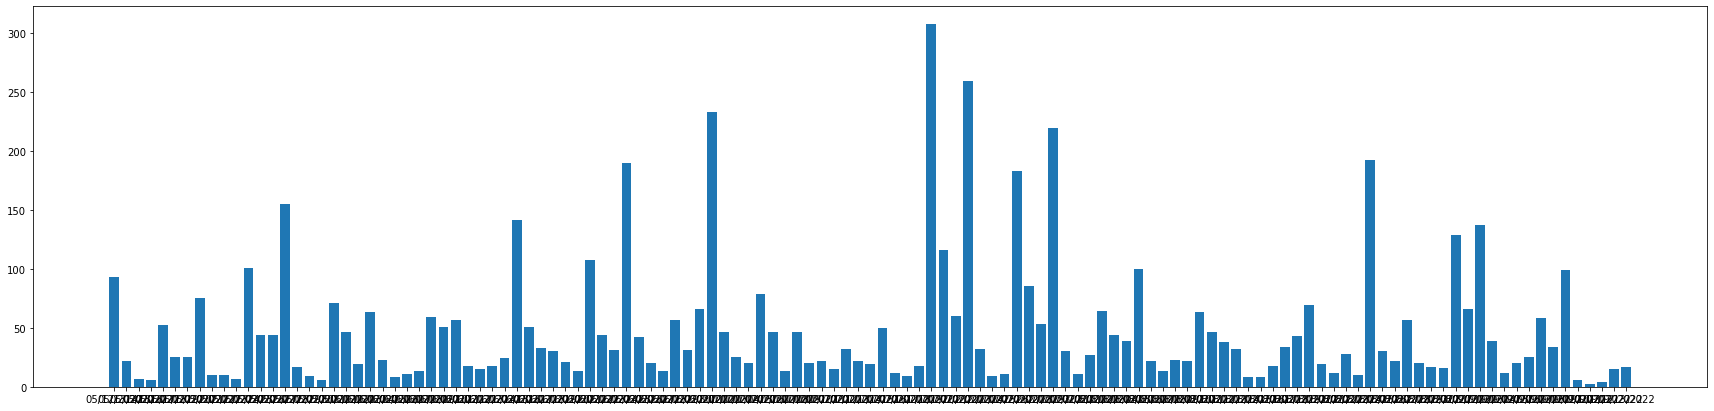

In [45]:
# Figure Size
plt.figure(figsize =(30, 7))
 
# Horizontal Bar Plot

plt.bar(book_pivot.columns[:-1], book_pivot.iloc[0:1,:-1].loc['All',:])
 
# Show Plot
plt.show()

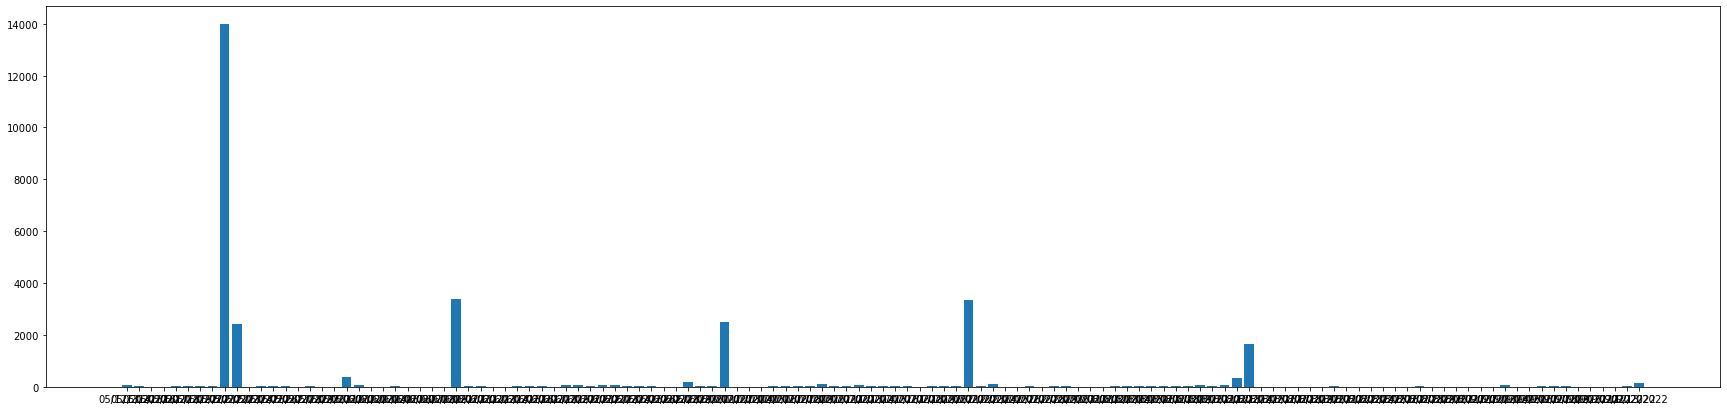

In [47]:
# Figure Size
plt.figure(figsize =(30, 7))
 
# Horizontal Bar Plot

plt.bar(lec_pivot.columns[:-1], lec_pivot.iloc[0:1,:-1].loc['All',:])
 
# Show Plot
plt.show()

In [51]:
lec_pivot.loc['All',:]>1000

date_paid
05/12/2022    False
05/13/2022    False
05/14/2022    False
05/15/2022    False
05/16/2022    False
05/17/2022    False
05/18/2022    False
05/19/2022    False
05/20/2022     True
05/21/2022     True
05/22/2022    False
05/23/2022    False
05/24/2022    False
05/25/2022    False
05/26/2022    False
05/27/2022    False
05/28/2022    False
05/29/2022    False
05/30/2022    False
05/31/2022    False
06/01/2022    False
06/02/2022    False
06/03/2022    False
06/04/2022    False
06/05/2022    False
06/06/2022    False
06/07/2022    False
06/08/2022     True
06/09/2022    False
06/10/2022    False
06/11/2022    False
06/12/2022    False
06/13/2022    False
06/14/2022    False
06/15/2022    False
06/16/2022    False
06/17/2022    False
06/18/2022    False
06/19/2022    False
06/20/2022    False
06/21/2022    False
06/22/2022    False
06/23/2022    False
06/24/2022    False
06/25/2022    False
06/26/2022    False
06/27/2022    False
06/28/2022    False
06/29/2022    False
06/30/2022

# 이상한 책 확인

In [58]:
# df_book['date_paid'] = df_book['date_paid'].dt.strftime('%m/%d/%Y')
df_book

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
1,627c50279d9388002406326a,2022-03-24T01:25:28.483Z,40000.0,38800.0,26.0,05/12/2022,5d838c7f3f0e6805c4706894,True,장골의 PI 변위는 없다,5cf8bbba0098b2225c5dfaa3,623bc8886f766b0024668eb5,1.0,38800.0,38800.0,30-39,1.0,0.0,False,도서,book
3,627c519c9d93880024063275,2022-04-28T08:08:41.248Z,210000.0,199500.0,0.0,05/12/2022,5ebc8bee09982e0735b2d835,True,초음파 가이드 근골격계 통증 치료의 정석,5cf8bbba0098b2225c5dfaa3,626a4b89e1579900234bd4af,1.0,199500.0,199500.0,30-39,1.0,1.0,False,도서,book
4,627c51ca9d93880024063280,2022-04-28T08:08:41.248Z,210000.0,199500.0,0.0,05/12/2022,5d931d770dabe405b156d63b,True,초음파 가이드 근골격계 통증 치료의 정석,5cf8bbba0098b2225c5dfaa3,626a4b89e1579900234bd4af,1.0,199500.0,199500.0,30-39,1.0,1.0,False,도서,book
5,627c51c69d9388002406327e,2022-04-28T08:08:41.248Z,210000.0,199500.0,0.0,05/12/2022,5f6be49c48060c52caf1528e,True,초음파 가이드 근골격계 통증 치료의 정석,5cf8bbba0098b2225c5dfaa3,626a4b89e1579900234bd4af,1.0,199500.0,199500.0,50-59,1.0,1.0,False,도서,book
6,627c51de9d93880024063289,2022-04-28T08:08:41.248Z,210000.0,199500.0,0.0,05/12/2022,5daf9e520dabe405b156f082,True,초음파 가이드 근골격계 통증 치료의 정석,5cf8bbba0098b2225c5dfaa3,626a4b89e1579900234bd4af,1.0,199500.0,199500.0,40-49,1.0,1.0,False,도서,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50097,63202f736c2e37002369f06e,2021-10-28T05:52:44.081Z,65000.0,58500.0,52.0,09/13/2022,5dee019d4267e105dffef02d,True,트리거포인트 침치료,5cf8bbba0098b2225c5dfaa3,617a3aacbc63410023471ab6,1.0,58500.0,58500.0,20-29,1.0,0.0,False,도서,book
50103,632033be6c2e37002369f09a,2022-04-12T06:34:15.781Z,30000.0,28500.0,11.0,09/13/2022,617e903bbc6341002347262a,True,스파이랄 및 키네지오 테이핑,5cf8bbba0098b2225c5dfaa3,62551d67cb28e6002469d8fb,1.0,28500.0,28500.0,None,1.0,1.0,False,도서,book
50113,63203ac86c2e37002369f0e7,2020-02-11T02:48:24.348Z,55000.0,49500.0,51.0,09/13/2022,6136d8e597686100197d7db2,True,소아피부질환해설,5cf8bbba0098b2225c5dfaa3,5e4215f84267e105dfff17b9,1.0,49500.0,49500.0,40-49,1.0,1.0,False,도서,book
50122,632024716c2e37002369f008,2019-12-09T02:48:00.845Z,40000.0,36000.0,21.0,09/13/2022,5e5f01c7bfe4260944782d10,True,한의 피부진료 첫 걸음,5cf8bbba0098b2225c5dfaa3,5dedb5e04267e105dffeef43,1.0,36000.0,36000.0,30-39,1.0,1.0,False,도서,book
